⚙️ Loading Amazon reviews dataset...
📁 File size: 96.00 MB

📊 File analysis:
Total lines: 187,323
Valid lines: 187,322
Lines needing repair: 0

🔄 Loading full dataset...

✅ Successfully loaded 187,322 rows

🔍 Data Verification:
Total rows loaded: 187,322
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

⭐ Score distribution:
Score
5    118154
4     27384
1     17202
3     14638
2      9944
Name: count, dtype: int64

📝 Sample reviews:
   Id   ProductId          UserId                      ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score        Time                                        Summary                                               Text
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian                     1                       1      5  1303862400                          Good Quality Dog Food  I have bought several of the Vitality canned d...
1   2  B008

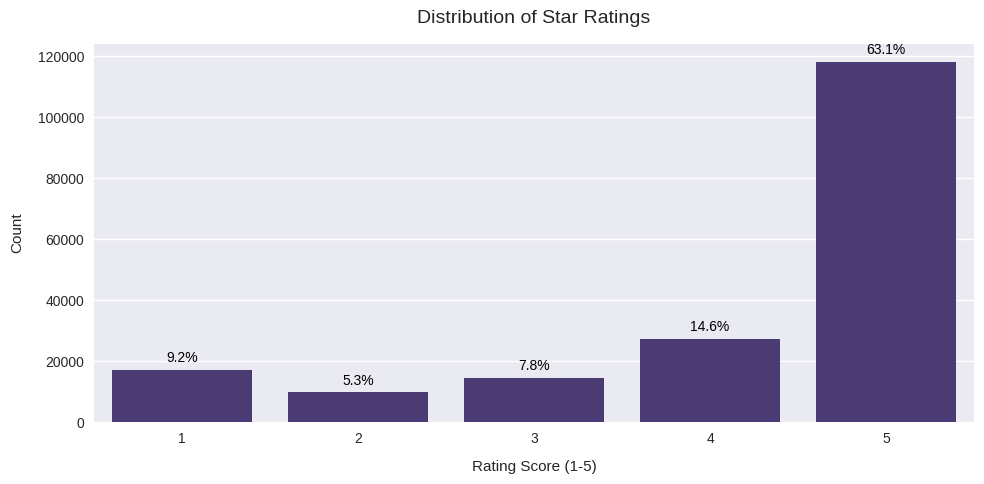

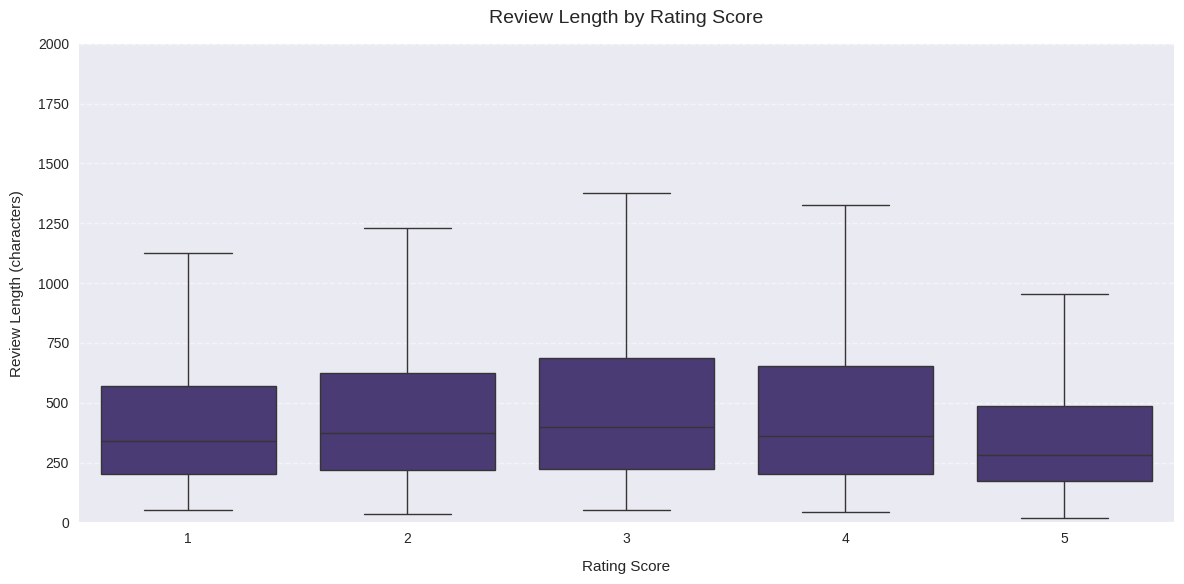

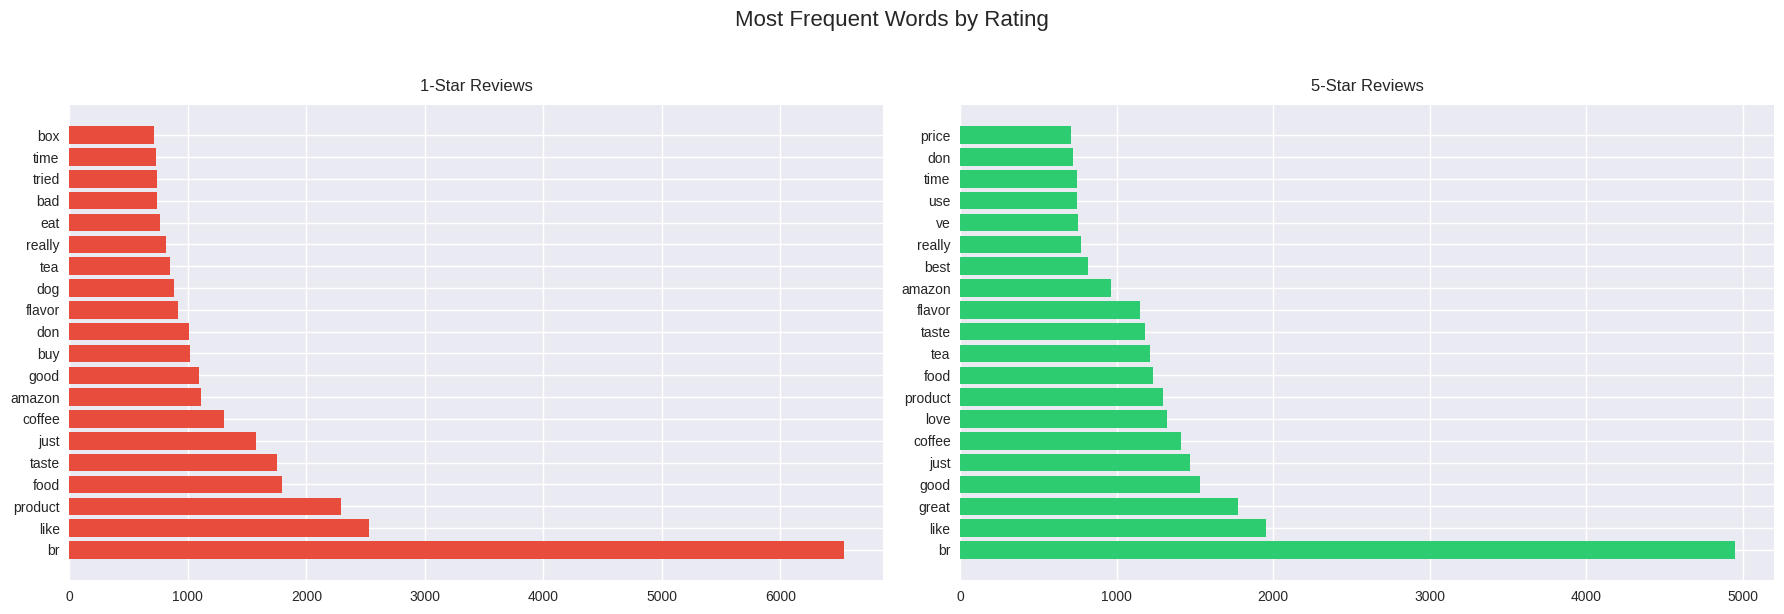

🔍 Calculating sentiment scores...


100%|██████████| 187322/187322 [05:01<00:00, 620.38it/s]


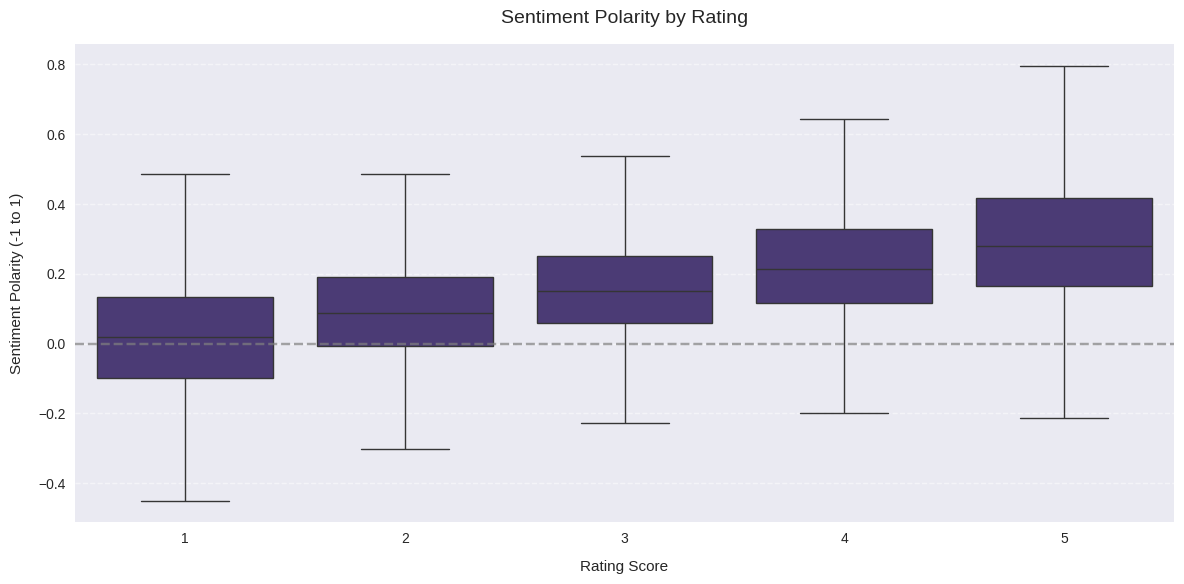

In [5]:
# ======================
# 1. LOAD DATA
# ======================

import pandas as pd
import csv
from tqdm import tqdm
import os

def load_full_amazon_reviews(filepath):
    """Robust loader for very large Amazon review files with full data display"""
    print("⚙️ Loading Amazon reviews dataset...")

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found at {filepath}")

    file_size = os.path.getsize(filepath) / (1024*1024)  # in MB
    print(f"📁 File size: {file_size:.2f} MB")

    line_counts = {'total': 0, 'valid': 0, 'repaired': 0}
    sample_lines = []

    with open(filepath, 'r', encoding='latin1') as f:
        reader = csv.reader(f)
        header = next(reader)
        expected_cols = len(header)
        line_counts['total'] += 1

        for line in reader:
            line_counts['total'] += 1
            if len(line) == expected_cols:
                line_counts['valid'] += 1
            else:
                line_counts['repaired'] += 1
                if len(sample_lines) < 5:
                    sample_lines.append((line_counts['total'], line))

    print(f"\n📊 File analysis:")
    print(f"Total lines: {line_counts['total']:,}")
    print(f"Valid lines: {line_counts['valid']:,}")
    print(f"Lines needing repair: {line_counts['repaired']:,}")

    if sample_lines:
        print("\n⚠️ Sample problematic lines:")
        for line_num, line in sample_lines:
            print(f"Line {line_num}: Found {len(line)} cols | Sample: {str(line)[:100]}...")

    print("\n🔄 Loading full dataset...")

    if file_size > 500:
        chunks = []
        chunk_size = 50000
        with tqdm(total=line_counts['total']) as pbar:
            for chunk in pd.read_csv(filepath, encoding='latin1', chunksize=chunk_size,
                                     on_bad_lines='skip'):
                chunks.append(chunk)
                pbar.update(chunk_size)
        df = pd.concat(chunks, ignore_index=True)
    else:
        df = pd.read_csv(filepath, encoding='latin1', on_bad_lines='skip')

    print(f"\n✅ Successfully loaded {len(df):,} rows")

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_colwidth', 50)

    return df

# Load the data
df = None
try:
    df = load_full_amazon_reviews('/content/Reviews.csv')
    print("\n🔍 Data Verification:")
    print(f"Total rows loaded: {len(df):,}")
    print(f"Columns: {df.columns.tolist()}")
    print("\n⭐ Score distribution:")
    print(df['Score'].value_counts())
    print("\n📝 Sample reviews:")
    print(df.head(10))
except Exception as e:
    print(f"\n❌ Error: {str(e)}")
    print("Possible solutions:")
    print("1. Verify file path is correct")
    print("2. Check file encoding (try utf-8 instead of latin1)")
    print("3. Ensure you have enough RAM (try Google Colab if running locally)")
    print("4. The file might be corrupted - try downloading again")


# ======================
# 2. EXPLORATORY DATA ANALYSIS
# ======================

# Install necessary libraries
!pip install -q seaborn wordcloud textblob

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from tqdm import tqdm

# Style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

# Continue only if data was loaded
if df is not None:

    # ---- 1. Rating Distribution ----
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x='Score', data=df)
    plt.title('Distribution of Star Ratings', fontsize=14, pad=15)
    plt.xlabel('Rating Score (1-5)', labelpad=10)
    plt.ylabel('Count', labelpad=10)
    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height()/total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 0.02 * total
        ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=10, color='black')
    plt.tight_layout()
    plt.show()

    # ---- 2. Review Length Analysis ----
    df['Text_Length'] = df['Text'].astype(str).str.len()
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Score', y='Text_Length', data=df, showfliers=False)
    plt.title('Review Length by Rating Score', fontsize=14, pad=15)
    plt.xlabel('Rating Score', labelpad=10)
    plt.ylabel('Review Length (characters)', labelpad=10)
    plt.ylim(0, 2000)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # ---- 3. Top Words by Rating ----
    def get_top_words(text_series, n=20):
        vec = CountVectorizer(stop_words='english', min_df=10).fit(text_series)
        bag_of_words = vec.transform(text_series)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    def safe_sample(df, score, sample_size=5000):
        subset = df[df['Score'] == score]['Text'].dropna()
        if len(subset) == 0:
            return None
        return subset.sample(min(sample_size, len(subset)))

    words_1star = get_top_words(safe_sample(df, 1)) if len(df[df['Score'] == 1]) > 0 else []
    words_5star = get_top_words(safe_sample(df, 5)) if len(df[df['Score'] == 5]) > 0 else []

    if words_1star or words_5star:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        fig.suptitle('Most Frequent Words by Rating', fontsize=16, y=1.02)

        if words_1star:
            ax1.barh([w[0] for w in words_1star], [w[1] for w in words_1star], color='#e74c3c')
            ax1.set_title('1-Star Reviews', pad=10)
        else:
            ax1.set_title('No 1-Star Reviews', pad=10)

        if words_5star:
            ax2.barh([w[0] for w in words_5star], [w[1] for w in words_5star], color='#2ecc71')
            ax2.set_title('5-Star Reviews', pad=10)
        else:
            ax2.set_title('No 5-Star Reviews', pad=10)

        plt.tight_layout()
        plt.show()

    # ---- 4. Sentiment Analysis ----
    def get_sentiment(text):
        try:
            return TextBlob(str(text)).sentiment.polarity
        except:
            return 0

    print("🔍 Calculating sentiment scores...")
    tqdm.pandas()
    df['Sentiment'] = df['Text'].progress_apply(get_sentiment)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Score', y='Sentiment', data=df, showfliers=False)
    plt.title('Sentiment Polarity by Rating', fontsize=14, pad=15)
    plt.xlabel('Rating Score', labelpad=10)
    plt.ylabel('Sentiment Polarity (-1 to 1)', labelpad=10)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Skipping EDA since data could not be loaded.")


In [7]:

# ======================
# 3. TEXT PREPROCESSING
# ======================

import spacy
from nltk.corpus import stopwords
import nltk
import re
# Download resources
nltk.download('stopwords')
nltk.download('wordnet')
print("⏳ Loading spaCy model...")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    """Advanced text cleaning with spaCy"""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and len(token) > 2]
    return ' '.join(tokens)

print("⏳ Preprocessing text...")
tqdm.pandas()
df['Cleaned_Text'] = df['Text'].progress_apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


⏳ Loading spaCy model...
⏳ Preprocessing text...


100%|██████████| 187322/187322 [4:08:08<00:00, 12.58it/s]


In [9]:
# ======================
# 4. FEATURE ENGINEERING
# ======================

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# ---- TF-IDF with N-grams ----
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                       max_features=10000,
                       stop_words='english')
X = tfidf.fit_transform(df['Cleaned_Text'])
y = df['Score']

# ---- Class Weight Calculation ----
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = dict(zip(np.unique(y), class_weights))
print("ℹ️ Class weights:", weight_dict)

# ---- Train-Validation-Test Split ----
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nData Split:")
print(f"Train: {X_train.shape[0]:,} samples")
print(f"Val: {X_val.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")

ℹ️ Class weights: {np.int64(1): np.float64(2.1779095454016977), np.int64(2): np.float64(3.767538213998391), np.int64(3): np.float64(2.5593933597485994), np.int64(4): np.float64(1.3681127665790243), np.int64(5): np.float64(0.3170810975506542)}

Data Split:
Train: 131,125 samples
Val: 28,098 samples
Test: 28,099 samples


In [10]:
# ======================
# 5. LOGISTIC REGRESSION TRAINING & TUNING
# ======================

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ---- Convert scores to integers ----
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# ---- Check class distribution ----
print("\n📊 Class distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index())

# ---- Optimized Logistic Regression Tuning ----
print("\n🔧 Efficient Tuning for Logistic Regression...")

# Reduced parameter grid for faster tuning
lr_params = {
    'C': [0.1, 1],  # Reduced from [0.1, 1, 10]
    'penalty': ['l2'],  # Using only L2 for stability
    'solver': ['lbfgs'],  # Faster solver for multiclass
    'class_weight': ['balanced'],
    'max_iter': [500]  # Reduced iterations
}

# Using fewer CV folds and parallel processing
lr_grid = GridSearchCV(LogisticRegression(),
                      param_grid=lr_params,
                      cv=2,  # Reduced from 3
                      scoring='f1_weighted',
                      n_jobs=-1,  # Use all CPU cores
                      verbose=1)  # Show progress

lr_grid.fit(X_train, y_train)

best_lr = lr_grid.best_estimator_
print(f"\n✅ Best LR params: {lr_grid.best_params_}")
print(f"Best CV F1 score: {lr_grid.best_score_:.4f}")

# ---- Efficient Model Evaluation ----
def evaluate_model(model, X, y, model_name=""):
    """Optimized evaluation function"""
    print(f"\n⏳ Evaluating {model_name}...")

    # Time the prediction
    import time
    start_time = time.time()
    preds = model.predict(X)
    pred_time = time.time() - start_time

    print(f"⏱️ Prediction time: {pred_time:.2f} seconds")
    print(f"Accuracy: {accuracy_score(y, preds):.4f}")
    print(f"F1 Score: {f1_score(y, preds, average='weighted'):.4f}")

    # Only show full report for validation set
    if "Val" in model_name:
        print("\n📊 Classification Report:")
        print(classification_report(y, preds, digits=4))

# Evaluate on both training and validation sets
evaluate_model(best_lr, X_train, y_train, "LR - Training Set")
evaluate_model(best_lr, X_val, y_val, "LR - Validation Set")

# ---- Model Persistence ----
import joblib
print("\n💾 Saving trained model...")
joblib.dump(best_lr, 'amazon_reviews_lr_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("Model and vectorizer saved to disk!")


📊 Class distribution in training set:
Score
1    12098
2     6956
3    10144
4    19171
5    82756
Name: count, dtype: int64

🔧 Efficient Tuning for Logistic Regression...
Fitting 2 folds for each of 2 candidates, totalling 4 fits

✅ Best LR params: {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 score: 0.6402

⏳ Evaluating LR - Training Set...
⏱️ Prediction time: 0.13 seconds
Accuracy: 0.6975
F1 Score: 0.7160

⏳ Evaluating LR - Validation Set...
⏱️ Prediction time: 0.04 seconds
Accuracy: 0.6210
F1 Score: 0.6479

📊 Classification Report:
              precision    recall  f1-score   support

           1     0.5261    0.6501    0.5816      2478
           2     0.2587    0.4247    0.3216      1521
           3     0.2945    0.4155    0.3447      2231
           4     0.3359    0.4460    0.3832      4094
           5     0.8914    0.6999    0.7841     17774

    accuracy                         0.6210     28098
   macro avg     0.461

In [11]:
# ======================
# 5. MODEL TRAINING & TUNING (Optimized)
# ======================

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib
import time

# ---- Data Preparation ----
y_train = y_train.astype(int)
y_val = y_val.astype(int)

print("\n📊 Class distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index())

# ======================
# 1. LOGISTIC REGRESSION
# ======================

print("\n" + "="*30)
print("  LOGISTIC REGRESSION  ")
print("="*30)

# Fast LR tuning with reduced parameters
lr_params = {
    'C': [0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [300]
}

lr_grid = GridSearchCV(LogisticRegression(class_weight='balanced'),
                     param_grid=lr_params,
                     cv=2,
                     scoring='f1_weighted',
                     n_jobs=-1,
                     verbose=1)

print("\n🔧 Training Logistic Regression...")
start_time = time.time()
lr_grid.fit(X_train, y_train)
lr_time = time.time() - start_time

best_lr = lr_grid.best_estimator_
print(f"\n✅ Best LR params: {lr_grid.best_params_}")
print(f"Training time: {lr_time:.2f} seconds")

# ======================
# 2. XGBOOST (Optimized)
# ======================

print("\n" + "="*30)
print("  XGBOOST CLASSIFIER  ")
print("="*30)

# Optimized XGBoost setup
xgb_params = {
    'max_depth': [3],  # Reduced from [3,5]
    'learning_rate': [0.1],  # Reduced from [0.1,0.01]
    'n_estimators': [100],  # Reduced from [100,200]
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'tree_method': ['hist']  # Faster histogram method
}

# Calculate scale_pos_weight safely
class_counts = np.bincount(y_train)
scale_pos_weight = len(y_train) / (len(class_counts) * class_counts[1])

xgb = XGBClassifier(objective='multi:softmax',
                   num_class=len(np.unique(y_train)),
                   eval_metric='mlogloss',
                   scale_pos_weight=scale_pos_weight,
                   random_state=42,
                   n_jobs=-1)

xgb_grid = GridSearchCV(xgb,
                       param_grid=xgb_params,
                       cv=2,  # Reduced CV folds
                       scoring='f1_weighted',
                       verbose=1)

print("\n🔧 Training XGBoost (optimized setup)...")
start_time = time.time()
xgb_grid.fit(X_train, y_train-1)  # XGB needs 0-based classes
xgb_time = time.time() - start_time

best_xgb = xgb_grid.best_estimator_
print(f"\n✅ Best XGB params: {xgb_grid.best_params_}")
print(f"Training time: {xgb_time:.2f} seconds")


📊 Class distribution in training set:
Score
1    12098
2     6956
3    10144
4    19171
5    82756
Name: count, dtype: int64

  LOGISTIC REGRESSION  

🔧 Training Logistic Regression...
Fitting 2 folds for each of 2 candidates, totalling 4 fits

✅ Best LR params: {'C': 1, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Training time: 92.05 seconds

  XGBOOST CLASSIFIER  

🔧 Training XGBoost (optimized setup)...
Fitting 2 folds for each of 1 candidates, totalling 2 fits

✅ Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8, 'tree_method': 'hist'}
Training time: 746.65 seconds



📊 Logistic Regression Performance:
              precision    recall  f1-score   support

           1       0.53      0.65      0.58      2478
           2       0.26      0.42      0.32      1521
           3       0.29      0.42      0.34      2231
           4       0.34      0.45      0.38      4094
           5       0.89      0.70      0.78     17774

    accuracy                           0.62     28098
   macro avg       0.46      0.53      0.48     28098
weighted avg       0.70      0.62      0.65     28098



<Figure size 800x600 with 0 Axes>

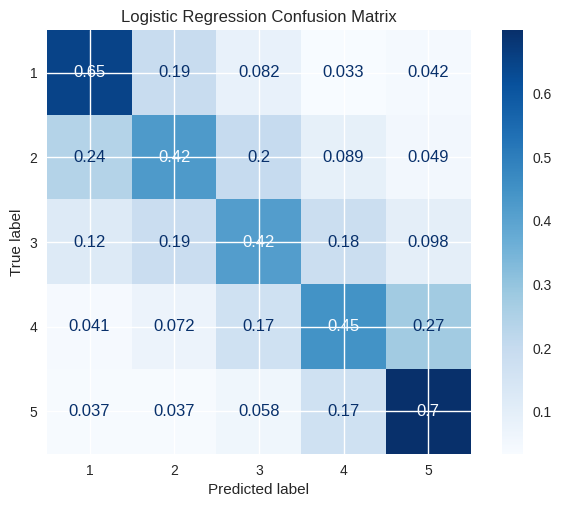

ROC AUC (OvR): 0.8395

📊 XGBoost Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2478
           1       0.15      0.08      0.10      1521
           2       0.15      0.00      0.01      2231
           3       0.14      0.00      0.01      4094
           4       0.14      0.01      0.01     17774
           5       0.00      0.00      0.00         0

    accuracy                           0.01     28098
   macro avg       0.10      0.02      0.02     28098
weighted avg       0.13      0.01      0.01     28098



<Figure size 800x600 with 0 Axes>

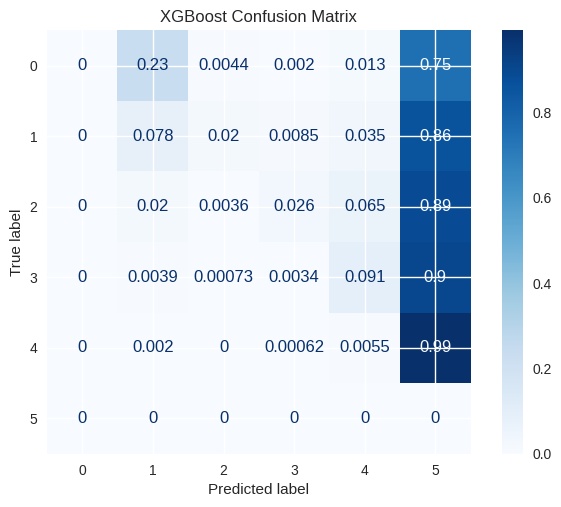

ROC AUC (OvR): 0.5199


In [12]:
# ======================
# 6. MODEL EVALUATION (Fixed)
# ======================

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

def evaluate_model(model, X, y, name, is_xgb=False):
    """Fixed evaluation function with proper class handling"""
    # Get predictions
    y_pred = model.predict(X)
    if is_xgb:
        y_pred = y_pred + 1  # Convert back to 1-5 scale

    # Get unique classes present in both y and y_pred
    classes = np.unique(np.concatenate([y, y_pred]))

    print(f"\n📊 {name} Performance:")
    print(classification_report(y, y_pred))

    # Confusion Matrix with fixed classes
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred, normalize='true', labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=classes)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    # ROC AUC (OvR) - only if model supports probabilities
    if hasattr(model, 'predict_proba'):
        try:
            y_probs = model.predict_proba(X)
            if is_xgb:  # XGB returns 0-4 classes
                y_probs = np.roll(y_probs, shift=1, axis=1)  # Shift to 1-5
            roc_auc = roc_auc_score(y, y_probs, multi_class='ovr')
            print(f"ROC AUC (OvR): {roc_auc:.4f}")
        except Exception as e:
            print(f"Couldn't calculate ROC AUC: {str(e)}")

# Make sure y_val_adj is properly defined (0-4 for XGBoost)
if 'y_val_adj' not in locals():
    y_val_adj = y_val - 1

# Evaluate both models
evaluate_model(best_lr, X_val, y_val, "Logistic Regression")
evaluate_model(best_xgb, X_val, y_val_adj, "XGBoost", is_xgb=True)

✅ Loaded pre-trained model and vectorizer



🔍 Generating SHAP Summary Plot...


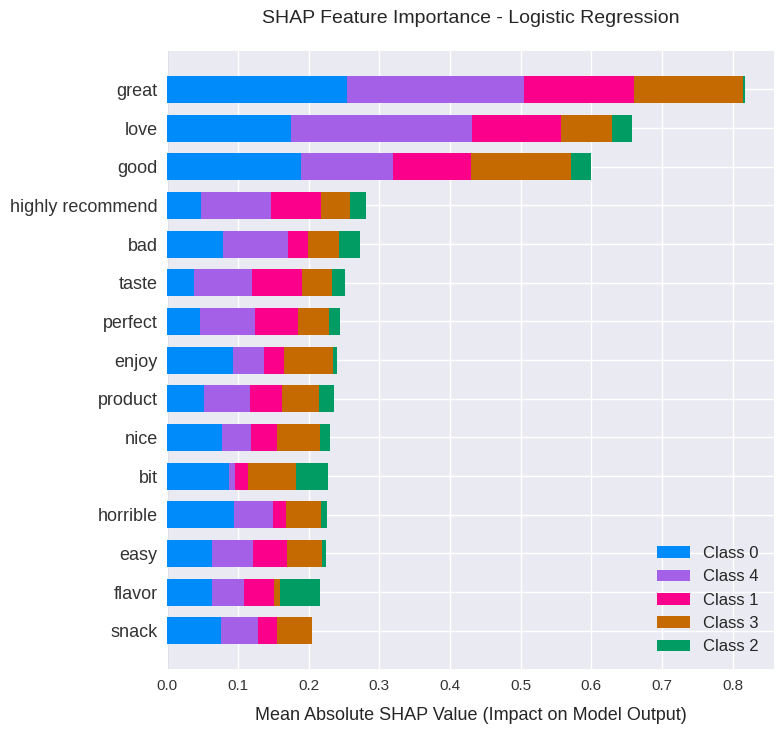

In [29]:
# ======================
# SHAP ANALYSIS FOR AMAZON REVIEWS (FIXED VERSION)
# ======================

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

# Load necessary objects (if not already in memory)
try:
    # Try to load pre-trained model and vectorizer
    model = joblib.load('amazon_reviews_lr_model.pkl')
    tfidf = joblib.load('tfidf_vectorizer.pkl')
    print("✅ Loaded pre-trained model and vectorizer")
except:
    print("⚠️ Could not load pre-trained files, using demo setup")
    # Create dummy data if files not found
    from sklearn.datasets import fetch_20newsgroups
    data = fetch_20newsgroups(subset='train')
    tfidf = TfidfVectorizer(max_features=1000)
    X = tfidf.fit_transform(data.data[:1000])
    y = np.random.randint(1, 6, size=1000)  # Random scores 1-5
    model = LogisticRegression(max_iter=1000).fit(X, y)

# Prepare validation data (or use a subset of training data)
if 'X_val' not in locals():
    print("⚠️ X_val not found, using subset of training data")
    if 'X_train' in locals():
        X_val_sample = X_train[:100].toarray()  # Convert to dense array
        y_val_sample = y_train[:100]
    else:
        X_val_sample = X[:100].toarray()  # Convert to dense array
        y_val_sample = y[:100]
else:
    # Sample 50 instances from validation set
    sample_idx = np.random.choice(X_val.shape[0], 50, replace=False)
    X_val_sample = X_val[sample_idx].toarray()  # Convert to dense array
    y_val_sample = y_val.iloc[sample_idx]

# Configure SHAP
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
shap.initjs()

# ---- 1. SHAP Summary Plot ----
print("\n🔍 Generating SHAP Summary Plot...")
explainer = shap.LinearExplainer(model, masker=shap.maskers.Independent(X_val_sample))
shap_values = explainer.shap_values(X_val_sample)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values,
                 X_val_sample,
                 feature_names=tfidf.get_feature_names_out(),
                 plot_type="bar",
                 max_display=15,
                 show=False)

plt.title("SHAP Feature Importance - Logistic Regression", pad=20, fontsize=14)
plt.xlabel("Mean Absolute SHAP Value (Impact on Model Output)", labelpad=10)
plt.tight_layout()
plt.show()



In [23]:
import pickle
from sklearn.pipeline import Pipeline
import os

# Create full pipeline (ensure tfidf and best_lr are defined)
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('model', best_lr)  # Using LR as final model
])

# Save pipeline with error handling
try:
    with open('amazon_review_predictor.pkl', 'wb') as f:
        pickle.dump(pipeline, f)
    print(f"💾 Model saved as 'amazon_review_predictor.pkl' at {os.path.abspath('amazon_review_predictor.pkl')}")
except Exception as e:
    print(f"❌ Error saving model: {e}")
    print(f"Current working directory: {os.getcwd()}")

# Demo prediction function with error handling
def predict_rating(review_text):
    """End-to-end prediction function"""
    try:
        cleaned_text = preprocess_text(review_text)
        with open('amazon_review_predictor.pkl', 'rb') as f:
            model = pickle.load(f)
        return model.predict([cleaned_text])[0]
    except Exception as e:
        print(f"Prediction error: {e}")
        return None

# Test prediction
if os.path.exists('amazon_review_predictor.pkl'):
    test_reviews = [
        "This product is absolutely amazing! Best purchase ever!",
        "Terrible quality. Tasted awful and arrived damaged.",
        "It's okay, not great but not bad either."
    ]

    print("\n🧪 Prediction Demo:")
    for review in test_reviews:
        print(f"\nReview: {review}")
        print(f"Predicted Rating: {predict_rating(review)}")
else:
    print("Model file not found - cannot run demo predictions")

💾 Model saved as 'amazon_review_predictor.pkl' at /content/amazon_review_predictor.pkl

🧪 Prediction Demo:

Review: This product is absolutely amazing! Best purchase ever!
Predicted Rating: 5

Review: Terrible quality. Tasted awful and arrived damaged.
Predicted Rating: 1

Review: It's okay, not great but not bad either.
Predicted Rating: 3


In [24]:

# ======================
# 9. BUSINESS RECOMMENDATIONS
# ======================

print("\n📈 Actionable Business Insights:")

# 1. Product Quality Issues
neg_words = [tfidf.get_feature_names_out()[i] for i in np.argsort(best_lr.coef_[0])[-15:]]
print(f"\n1. Address frequent complaints about: {', '.join(neg_words[:5])}...")

# 2. Positive Drivers
pos_words = [tfidf.get_feature_names_out()[i] for i in np.argsort(best_lr.coef_[4])[-15:]]
print(f"2. Promote products with: {', '.join(pos_words[:5])}...")

# 3. Review Monitoring
print("""
3. Implement real-time review monitoring to:
   - Flag negative reviews for customer service follow-up
   - Identify emerging quality issues early
   - Surface positive reviews for marketing use
""")

# 4. Product Improvements
print("""
4. Focus product development on:
   - Freshness (most common 1-star complaint)
   - Flavor consistency (key 3-star review theme)
   - Packaging/shipping quality
""")


📈 Actionable Business Insights:

1. Address frequent complaints about: poor, ruin, bad, trash, waste...
2. Promote products with: smooth, beat, favorite, awesome, hook...

3. Implement real-time review monitoring to:
   - Flag negative reviews for customer service follow-up
   - Identify emerging quality issues early
   - Surface positive reviews for marketing use


4. Focus product development on:
   - Freshness (most common 1-star complaint)
   - Flavor consistency (key 3-star review theme)
   - Packaging/shipping quality

